In [1]:
import pandas as pd
import numpy as np

In [2]:
df=pd.read_csv('data/df_ml.csv', sep=",")
#df['Date'] = pd.to_datetime(df['Date'])

#df.drop(index=1, inplace=True)
df.head(3)

,Open,High,Low,Close,Adj Close,Volume($),Symbol,Daily Return,SMA_30,SMA_60,...,Close_rolling_std_7,Volume_rolling_mean_7,Volume_rolling_std_7,Close_rolling_mean_30,Close_rolling_std_30,Volume_rolling_mean_30,Volume_rolling_std_30,Year,Month,Day
0,28994.009766,29600.626953,28803.585938,29374.152344,29374.152344,40730301359,BTC,0.012842,22428.243750,19715.608773,...,1284.059118,4.970113e+10,8.115395e+09,22428.243750,3661.566866,3.886562e+10,1.223869e+10,2021,1,1
1,29376.455078,33155.117188,29091.181641,32127.267578,32127.267578,67865420765,BTC,0.093726,22850.972721,20018.558219,...,1936.633106,5.249153e+10,1.055716e+10,22850.972721,4019.854985,4.006346e+10,1.325301e+10,2021,1,2
2,32129.408203,34608.558594,32052.316406,32782.023438,32782.023438,78665235202,BTC,0.020380,23320.381315,20329.363493,...,2189.909798,5.423229e+10,1.376529e+10,23320.381315,4328.735995,4.155655e+10,1.494648e+10,2021,1,3


In [3]:
#allowed_cryptos = ['BTC', 'ETH', 'USDT', 'BNB', 'SOL', 'XRP', 'ADA', 'AVAX', 'DOGE']
# Filter the DataFrame to include only the rows with symbols in the allowed list
#df = df[df['Symbol'].isin(allowed_cryptos)]

In [4]:
df = df[['Symbol','Close', 'Close_lag_1', 'Low','Midpoint','High','Open','Close_lag_3']] #
#df = df[['Close','Symbol','Close_lag_7','EMA_90', '90_day_MA', 'Close_rolling_mean_30','EMA_60','EMA_26','SMA_30']]
#df.head(1)



28             Close_lag_7        1
12                  EMA_90        1
23               90_day_MA        1
34   Close_rolling_mean_30        1
11                  EMA_60        2
15                  EMA_26        3
7                   SMA_30        4

In [5]:
df

,Symbol,Close,Close_lag_1,Low,Midpoint,High,Open,Close_lag_3
0,BTC,29374.152344,29001.720703,28803.585938,29202.106445,29600.626953,28994.009766,27362.437500
1,BTC,32127.267578,29374.152344,29091.181641,31123.149414,33155.117188,29376.455078,28840.953125
2,BTC,32782.023438,32127.267578,32052.316406,33330.437500,34608.558594,32129.408203,29001.720703
3,BTC,31971.914062,32782.023438,28722.755859,31081.487305,33440.218750,32810.949219,29374.152344
4,BTC,33992.429688,31971.914062,30221.187500,32329.388672,34437.589844,31977.041016,32127.267578
...,...,...,...,...,...,...,...,...
16039,TON,2.160291,2.135291,2.101517,2.132578,2.163639,2.143799,2.045980
16040,TON,2.587086,2.160291,2.156239,2.397342,2.638445,2.159645,2.092255
16041,TON,2.539670,2.587086,2.424762,2.578523,2.732283,2.592313,2.135291
16042,TON,2.425865,2.539670,2.418916,2.483391,2.547866,2.544140,2.160291


#### Onehot encoding 

In [6]:
from sklearn.preprocessing import OneHotEncoder

# Initialize OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)

artists_column = df['Symbol'].values.reshape(-1, 1)

one_hot_encoded_artists = one_hot_encoder.fit_transform(artists_column)

df['Symbol'] = np.argmax(one_hot_encoded_artists, axis=1)

d:\Anaconda\envs\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


#### Scaling and Spliting train,test,validation

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split data into features (X) and target variable (y)
X = df.drop('Close', axis=1)  
y = df['Close']

# Split the dataset into training (70%), validation (15%), and test (15%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.fit_transform(X)


## Machine Learning Models

### LSTM

In [8]:
lstm_test = df

In [9]:
df

,Symbol,Close,Close_lag_1,Low,Midpoint,High,Open,Close_lag_3
0,3,29374.152344,29001.720703,28803.585938,29202.106445,29600.626953,28994.009766,27362.437500
1,3,32127.267578,29374.152344,29091.181641,31123.149414,33155.117188,29376.455078,28840.953125
2,3,32782.023438,32127.267578,32052.316406,33330.437500,34608.558594,32129.408203,29001.720703
3,3,31971.914062,32782.023438,28722.755859,31081.487305,33440.218750,32810.949219,29374.152344
4,3,33992.429688,31971.914062,30221.187500,32329.388672,34437.589844,31977.041016,32127.267578
...,...,...,...,...,...,...,...,...
16039,10,2.160291,2.135291,2.101517,2.132578,2.163639,2.143799,2.045980
16040,10,2.587086,2.160291,2.156239,2.397342,2.638445,2.159645,2.092255
16041,10,2.539670,2.587086,2.424762,2.578523,2.732283,2.592313,2.135291
16042,10,2.425865,2.539670,2.418916,2.483391,2.547866,2.544140,2.160291


In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Normalize the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)  # Exclude 'Date' if it exists

# Define a function to create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length, -1]  # Assuming the target (e.g., 'Close') is the last column
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10  # Number of time steps to look back 
X, y = create_sequences(scaled_data, seq_length)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [11]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [12]:
# Adjust hyperparameters
hidden_dim = 100  # Number of LSTM units
num_layers = 4  # Number of LSTM layers
learning_rate = 0.01  # Learning rate for the optimizer
batch_size = 64  # Batch size for training
weight_decay = 1e-5  # L2 regularization term
output_dim = 1

input_dim = X_train.shape[2]

# Define the model
model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)

# Define the optimizer with weight decay
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = torch.nn.MSELoss()

# Define a DataLoader for batch processing
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

# Training loop with batch processing and gradient clipping
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    for i, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        
        optimizer.step()
    
    # Print loss every 10 epochs
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')


Epoch 0, Loss: 0.00010515263420529664
Epoch 10, Loss: 0.0003363928117323667
Epoch 20, Loss: 4.5402117393678054e-05
Epoch 30, Loss: 1.0079531421069987e-05
Epoch 40, Loss: 1.514035011496162e-05
Epoch 50, Loss: 4.335548055678373e-06
Epoch 60, Loss: 5.1357681513763964e-05
Epoch 70, Loss: 0.00010027491953223944
Epoch 80, Loss: 3.6828452721238136e-05
Epoch 90, Loss: 7.775407721055672e-05
Epoch 100, Loss: 1.238664935954148e-06
Epoch 110, Loss: 3.796442615566775e-05
Epoch 120, Loss: 0.00014252614346332848
Epoch 130, Loss: 2.954368756036274e-05
Epoch 140, Loss: 2.068939920718549e-06
Epoch 150, Loss: 1.1562775625861832e-06
Epoch 160, Loss: 5.393952233134769e-05
Epoch 170, Loss: 3.941933755413629e-06
Epoch 180, Loss: 1.2597273780556861e-05
Epoch 190, Loss: 5.3695213864557445e-05


In [13]:
# validation
model.eval()
predicted = model(X_test)
predicted = predicted.detach().numpy()
actual = y_test.numpy()

# You can use any metric for evaluation, here we use Mean Squared Error as an example
test_loss = criterion(model(X_test), y_test)
print(f'Test Loss: {test_loss.item()}')

# Remember to invert the scaling for actual predictions before comparing them!


Test Loss: 3.1144325021159602e-06


In [14]:
predicted_reshaped = np.zeros((len(predicted), scaled_data.shape[1]))   
predicted_reshaped[:, -1] = predicted.squeeze()   

actual_reshaped = np.zeros((len(actual), scaled_data.shape[1]))
actual_reshaped[:, -1] = actual.squeeze()

# Step 2: Apply the inverse transformation
predicted_inverse = scaler.inverse_transform(predicted_reshaped)[:, -1]  # Select the target column after inversion
actual_inverse = scaler.inverse_transform(actual_reshaped)[:, -1]



In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

mae = mean_absolute_error(actual_inverse, predicted_inverse)
rmse = np.sqrt(mean_squared_error(actual_inverse, predicted_inverse))
# MAPE function needs to handle division by zero, so we'll define it manually
mape = np.mean(np.abs((actual_inverse - predicted_inverse) / actual_inverse)) * 100

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")


Mean Absolute Error (MAE): 119.14739179365557
Root Mean Squared Error (RMSE): 119.2402706760134
Mean Absolute Percentage Error (MAPE): 11801.46554438578%


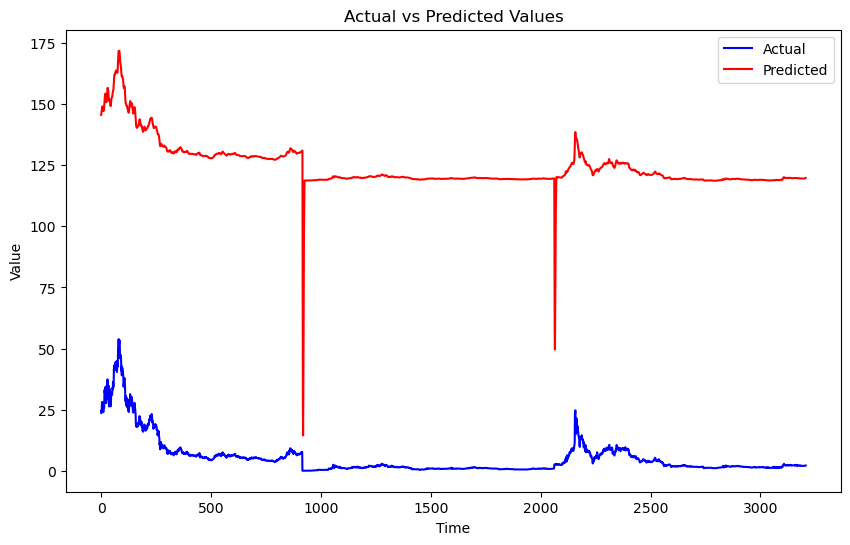

In [16]:
import matplotlib.pyplot as plt

# Assuming 'actual_inverse' and 'predicted_inverse' are your actual and predicted values respectively
plt.figure(figsize=(10,6))
plt.plot(actual_inverse, label='Actual', color='blue')
plt.plot(predicted_inverse, label='Predicted', color='red')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


In [17]:
#stop


In [18]:
df.to_csv('data/df_fs.csv', index=False)